<p align="center">
  <img src="IMG_14DF4D520FB0-1.jpeg" alt="End-to-end?">
</p>

In [389]:
import os
import pickle
import numpy as np
import torch
import random
import tqdm
import time

In [4]:
import matplotlib              as mpl
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [5]:
from behenate_net.aug import PadBottomRight, \
                             Pad,            \
                             Crop,           \
                             RandomCrop,     \
                             Resize,         \
                             RandomShift,    \
                             RandomRotate,   \
                             RandomPatch

In [6]:
from behenate_net.dataset   import BeHenateDataset
from behenate_net.model     import ConfigModel, BeHenataNet
from behenate_net.utils     import split_dataset, set_seed

In [7]:
seed = 0
set_seed(seed)

In [8]:
batch_size = 100
lr = 1e-3
frac_train = 0.6
frac_validate = 0.5

In [575]:
timestamp = "2023_0314_0941_45"
# epoch = 117
# epoch = 184
epoch = 311
fl_chkpt = f"{timestamp}.epoch_{epoch}.chkpt"

In [10]:
path_pickle = "beam_center.pickle"
with open(path_pickle, 'rb') as handle:
    data_list = pickle.load(handle)

# Split data...
data_train   , data_val_and_test = split_dataset(data_list        , frac_train   , seed = None)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = None)

In [11]:
len(data_train), len(data_validate), len(data_test)

(18, 6, 6)

In [12]:
img_orig, center_orig, metadata_orig = data_test[0]

In [332]:
size_img_y, size_img_x = (200, 200)
trans_list = (
    Pad(size_y = 2000, size_x = 2000),
    # Crop((940, 960), (200, 200)),
    RandomCrop(center_shift_max = (10, 10), crop_window_size = (1000, 1000)),
    Resize(size_img_y, size_img_x),
    RandomShift(0.5, 0.5),
    RandomRotate(angle_max = 20),
    # RandomPatch(num_patch = 10, size_patch_y = 10, size_patch_x = 10, var_patch_y = 0.2, var_patch_x = 0.2),
)

In [135]:
size_img_y, size_img_x = (200, 200)
trans_list = (
    Pad(size_y = 2000, size_x = 2000),
    # Crop((940, 960), (200, 200)),
    # RandomCrop(center_shift_max = (10, 10), crop_window_size = (1000, 1000)),
    Resize(size_img_y, size_img_x),
    RandomShift(0.1, 0.1),
    # RandomRotate(angle_max = 20),
    # RandomPatch(num_patch = 10, size_patch_y = 10, size_patch_x = 10, var_patch_y = 0.2, var_patch_x = 0.2),
)

In [576]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
config_model = ConfigModel( size_y = size_img_y, size_x = size_img_x, isbias = True )
model = BeHenataNet(config_model)
model.init_params(fl_chkpt = fl_chkpt)
model.to(device)

BeHenataNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): PReLU(num_parameters=1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [631]:
img_orig, center_orig, metadata_orig = data_test[4]
img = img_orig.copy()
center = center_orig
for trans in trans_list: img, center = trans(img, center)
img = (img - img.mean()) / img.std()    # Don't forget to normalize data.  I did it in the data loader.
# img[img > img.mean() + img.std()] = 0
# img[img < img.mean() - 2 * img.std()] = 0

time_start = time.monotonic()
img = torch.tensor(img[None, None,]).to(device, dtype = torch.float)
with torch.no_grad(): center_pred = model.predict(img)
time_end = time.monotonic()
print(f"time: {(time_end - time_start) * 1e3} ms.")

time: 684.6091356128454 ms.


(y, x) = [0.55534109 1.06496111]


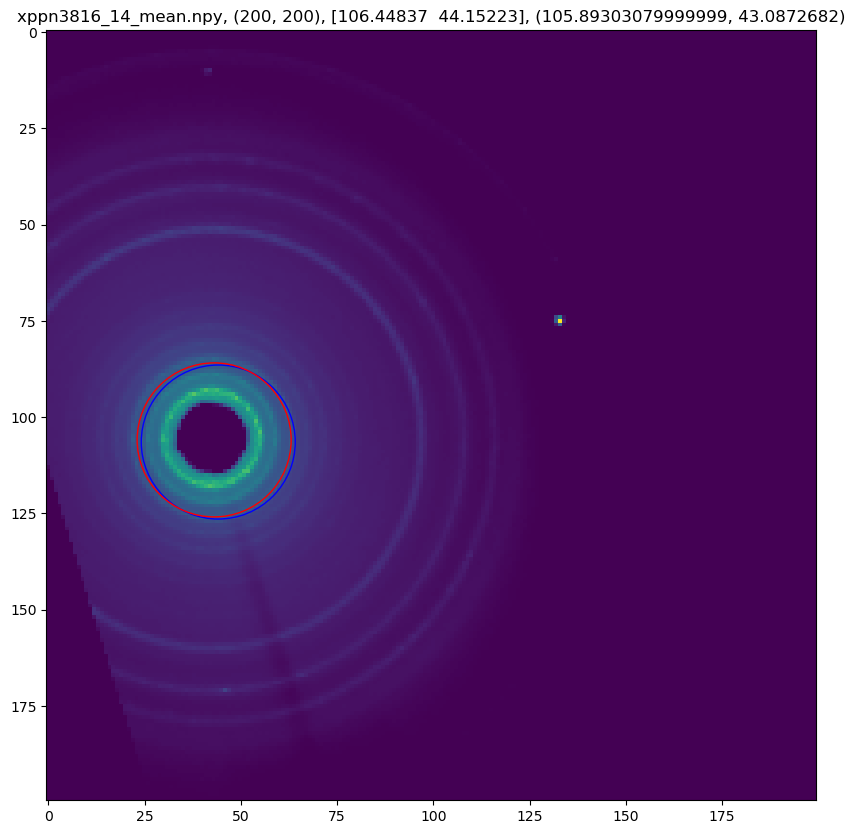

In [632]:
img = img[0, 0].cpu().numpy()
center_pred = center_pred[0].cpu().numpy()
size_y, size_x = img.shape

radius = 20
fig = plt.figure(figsize = (10, 10))
circle_pred = mpatches.Circle(center_pred[::-1], radius=radius, color='blue', fill=False)    # Err..., matplotlib uses (x, y) not (y, x)
circle      = mpatches.Circle(center[::-1], radius=radius, color='red', fill=False)    # Err..., matplotlib uses (x, y) not (y, x)

vmin = np.nanmedian(img)
vmax = np.nanmedian(img) + 8 * np.nanstd(img)
plt.imshow(img, vmin = vmin, vmax = vmax)
plt.gca().add_patch(circle_pred)
plt.gca().add_patch(circle)
plt.title(f"{metadata_orig}, {img.shape}, {center_pred}, {center}")
print(f"(y, x) = {center_pred - center}")

In [325]:
# img_orig, center_orig, metadata_orig = data_test[0]

# # img_padded, center_padded = trans_list[0](img_orig, center_orig)

# center_pred[0] *= 2000 / size_y
# center_pred[1] *= 2000 / size_x

# fig = plt.figure(figsize = (8, 8))
# circle_pred = mpatches.Circle(center_pred[::-1], radius=radius, color='blue', fill=False)    # Err..., matplotlib uses (x, y) not (y, x)
# circle      = mpatches.Circle(center_orig[::-1], radius=radius, color='red', fill=False)    # Err..., matplotlib uses (x, y) not (y, x)
# # circle      = mpatches.Circle(center_padded[::-1], radius=radius, color='red', fill=False)    # Err..., matplotlib uses (x, y) not (y, x)

# vmin = np.nanmedian(img_orig)
# vmax = np.nanmedian(img_orig) + 8 * np.nanstd(img_orig)
# plt.imshow(img_orig, vmin = vmin, vmax = vmax)
# plt.gca().add_patch(circle_pred)
# plt.gca().add_patch(circle)
# plt.title(f"{img.shape}, {center_pred}, {center_orig}")

# # vmin = np.nanmedian(img_padded)
# # vmax = np.nanmedian(img_padded) + 8 * np.nanstd(img_padded)
# # plt.imshow(img_padded, vmin = vmin, vmax = vmax)
# # plt.gca().add_patch(circle_pred)
# # plt.gca().add_patch(circle)
# # plt.title(f"{img.shape}, {center_pred}, {center_padded}")